# Optimization using Genetic Algorithm 

## 0. Import necessary Libraries

In [3]:
import pandas as pd
import geopandas as gpd
import networkx as nx
#import stellargraph as sg
from sklearn.metrics.pairwise import haversine_distances
import numpy as np
import matplotlib.pyplot as plt
import random
import math
import sys

## 1. Load the data 

In [5]:
# Load the data
shapefile_path = r"C:\Users\Paula\OneDrive\Matematicas y estadistia-UCM\Matematicas y estadistica\TFG\Base de datos\Data (1)\Data\taxi_zones\taxi_zones\taxi_zones.shp"
zone_info_path = r"C:\Users\Paula\OneDrive\Matematicas y estadistia-UCM\Matematicas y estadistica\TFG\Base de datos\Data (1)\Data\taxi_zone_lookup.csv"
demand_data_path = r"C:\Users\Paula\OneDrive\Matematicas y estadistia-UCM\Matematicas y estadistica\TFG\Base de datos\Data (1)\taxi_data_cols.csv"

taxi_zones = gpd.read_file(shapefile_path)
zone_info = pd.read_csv(zone_info_path)
demand_data = pd.read_csv(demand_data_path)

In [6]:
print(taxi_zones.head())

   OBJECTID  Shape_Leng  Shape_Area                     zone  LocationID  \
0         1    0.116357    0.000782           Newark Airport           1   
1         2    0.433470    0.004866              Jamaica Bay           2   
2         3    0.084341    0.000314  Allerton/Pelham Gardens           3   
3         4    0.043567    0.000112            Alphabet City           4   
4         5    0.092146    0.000498            Arden Heights           5   

         borough                                           geometry  
0            EWR  POLYGON ((933100.918 192536.086, 933091.011 19...  
1         Queens  MULTIPOLYGON (((1033269.244 172126.008, 103343...  
2          Bronx  POLYGON ((1026308.77 256767.698, 1026495.593 2...  
3      Manhattan  POLYGON ((992073.467 203714.076, 992068.667 20...  
4  Staten Island  POLYGON ((935843.31 144283.336, 936046.565 144...  


In [7]:
print(zone_info.head())

   LocationID        Borough                     Zone service_zone
0           1            EWR           Newark Airport          EWR
1           2         Queens              Jamaica Bay    Boro Zone
2           3          Bronx  Allerton/Pelham Gardens    Boro Zone
3           4      Manhattan            Alphabet City  Yellow Zone
4           5  Staten Island            Arden Heights    Boro Zone


In [8]:
print(demand_data.head())

   PULocationID  DOLocationID      pickup_datetime     dropoff_datetime  \
0          42.0          42.0  2022-01-01 00:14:21  2022-01-01 00:15:33   
1         116.0          41.0  2022-01-01 00:20:55  2022-01-01 00:29:38   
2          41.0         140.0  2022-01-01 00:57:02  2022-01-01 01:13:14   
3         181.0         181.0  2022-01-01 00:07:42  2022-01-01 00:15:57   
4          33.0         170.0  2022-01-01 00:07:50  2022-01-01 00:28:52   

   trip_distance  
0           0.44  
1           2.10  
2           3.70  
3           1.69  
4           6.26  


In [9]:
# Process the data
taxi_zones = taxi_zones.drop(columns=['LocationID'])
taxi_zones = taxi_zones.merge(zone_info, left_on="OBJECTID", right_on="LocationID")

In [10]:
print(taxi_zones.head())

   OBJECTID  Shape_Leng  Shape_Area                     zone        borough  \
0         1    0.116357    0.000782           Newark Airport            EWR   
1         2    0.433470    0.004866              Jamaica Bay         Queens   
2         3    0.084341    0.000314  Allerton/Pelham Gardens          Bronx   
3         4    0.043567    0.000112            Alphabet City      Manhattan   
4         5    0.092146    0.000498            Arden Heights  Staten Island   

                                            geometry  LocationID  \
0  POLYGON ((933100.918 192536.086, 933091.011 19...           1   
1  MULTIPOLYGON (((1033269.244 172126.008, 103343...           2   
2  POLYGON ((1026308.77 256767.698, 1026495.593 2...           3   
3  POLYGON ((992073.467 203714.076, 992068.667 20...           4   
4  POLYGON ((935843.31 144283.336, 936046.565 144...           5   

         Borough                     Zone service_zone  
0            EWR           Newark Airport          EWR  
1 

## 2. Process Data + Create Graph

In [12]:
# Filter to match unique zones in demand data
unique_zones_filtered = set(taxi_zones["LocationID"].unique()) - {103, 104, 110}
taxi_zones_filtered = taxi_zones[taxi_zones['OBJECTID'].isin(unique_zones_filtered)]

In [13]:
# Extract coordinates
taxi_zones_filtered['centroid'] = taxi_zones_filtered.centroid
taxi_zones_filtered['centroid_x'] = taxi_zones_filtered.centroid.x
taxi_zones_filtered['centroid_y'] = taxi_zones_filtered.centroid.y

coords = taxi_zones_filtered[['LocationID', 'centroid_x', 'centroid_y']]
coords_gdf = gpd.GeoDataFrame(coords, geometry=gpd.points_from_xy(coords.centroid_x, coords.centroid_y))
coords_gdf.set_crs(epsg=2263, inplace=True)
coords_gdf = coords_gdf.to_crs(epsg=4326)

coords_gdf['centroid_lat'] = np.radians(coords_gdf.geometry.y)
coords_gdf['centroid_lon'] = np.radians(coords_gdf.geometry.x)

C:\Users\Paula\anaconda3\envs\tf-gpu\lib\site-packages\geopandas\geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
C:\Users\Paula\anaconda3\envs\tf-gpu\lib\site-packages\geopandas\geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
C:\Users\Paula\anaconda3\envs\tf-gpu\lib\site-packages\geopandas\geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try

In [14]:
print(coords_gdf.head())

   LocationID    centroid_x     centroid_y                    geometry  \
0           1  9.359968e+05  191376.749531    POINT (-74.174 40.69183)   
1           2  1.031086e+06  164018.754403   POINT (-73.8313 40.61675)   
2           3  1.026453e+06  254265.478659  POINT (-73.84742 40.86447)   
3           4  9.906340e+05  202959.782391  POINT (-73.97697 40.72375)   
4           5  9.318714e+05  140681.351376  POINT (-74.18848 40.55266)   

   centroid_lat  centroid_lon  
0      0.710206     -1.294581  
1      0.708896     -1.288599  
2      0.713220     -1.288881  
3      0.710764     -1.291142  
4      0.707777     -1.294833  


In [15]:
# Create the graph
G = nx.Graph()
for _, row in coords.iterrows():
    G.add_node(row['LocationID'], pos=(row['centroid_x'], row['centroid_y']), features=[row['centroid_x'], row['centroid_y']])

coords_rad = coords_gdf[['centroid_lat', 'centroid_lon']].to_numpy()
distances = haversine_distances(coords_rad) * 6371000 / 1609.34  # Convert to miles

threshold_distance = 20  # Threshold in miles
for i, zone1 in enumerate(coords['LocationID']):
    for j, zone2 in enumerate(coords['LocationID']):
        if i != j and distances[i, j] < threshold_distance:
            G.add_edge(zone1, zone2, weight=distances[i, j])

node_features = pd.DataFrame.from_dict({node: data['features'] for node, data in G.nodes(data=True)}, orient='index')
#stellar_graph = sg.StellarGraph.from_networkx(G, node_features=node_features)
#adj_matrix = stellar_graph.to_adjacency_matrix()

In [16]:
merged_data = taxi_zones.merge(coords_gdf, on='LocationID')
merged_data['centroid_lat'] = merged_data['centroid_lat'].to_numpy()
merged_data['centroid_lon'] = merged_data['centroid_lon'].to_numpy()

print(merged_data.head())

   OBJECTID  Shape_Leng  Shape_Area                     zone        borough  \
0         1    0.116357    0.000782           Newark Airport            EWR   
1         2    0.433470    0.004866              Jamaica Bay         Queens   
2         3    0.084341    0.000314  Allerton/Pelham Gardens          Bronx   
3         4    0.043567    0.000112            Alphabet City      Manhattan   
4         5    0.092146    0.000498            Arden Heights  Staten Island   

                                          geometry_x  LocationID  \
0  POLYGON ((933100.918 192536.086, 933091.011 19...           1   
1  MULTIPOLYGON (((1033269.244 172126.008, 103343...           2   
2  POLYGON ((1026308.77 256767.698, 1026495.593 2...           3   
3  POLYGON ((992073.467 203714.076, 992068.667 20...           4   
4  POLYGON ((935843.31 144283.336, 936046.565 144...           5   

         Borough                     Zone service_zone    centroid_x  \
0            EWR           Newark Airport   

## 3. Create GA to solve the VRP

In [41]:
def genetic_algorithm_vrp(data, zones, vehicle_capacities, popsize, iterations, threshold_distance):
    """
    Solves the Vehicle Routing Problem using a Genetic Algorithm (GA).

    Parameters:
    data (pd.DataFrame): Merged data containing zones and coordinates.
    zones (list): List of zones to visit.
    vehicle_capacities (list): List of vehicle capacities.
    popsize (int): Population size for the genetic algorithm.
    iterations (int): Number of iterations to run the GA.
    threshold_distance (float): Maximum distance threshold for connecting nodes.

    Returns:
    list, float: The optimal route labels and the associated total cost.
    """
    
    # Select only the relevant zones
    selected_zones = data[data['zone'].isin(zones)]
    
    # Ensure the depot is first in vrp_nodes
    depot_zone = zones[0]
    depot_row = selected_zones[selected_zones['zone'] == depot_zone].iloc[0]
    depot = {'label': depot_row['zone'], 'demand': depot_row['demand'], 'posX': depot_row['centroid_lon'], 'posY': depot_row['centroid_lat']}
    selected_zones = selected_zones[selected_zones['zone'] != depot_zone]
    
    # Create VRP nodes, ensuring depot is the first node
    vrp_nodes = [depot] + [{'label': row['zone'], 'demand': row['demand'], 
                            'posX': row['centroid_lon'], 'posY': row['centroid_lat']} 
                 for _, row in selected_zones.iterrows()]

    def haversine_distance(n1, n2):
        """
        Calculate Haversine distance between two nodes.
        """
        coord1 = np.array([n1['posX'], n1['posY']])
        coord2 = np.array([n2['posX'], n2['posY']])
        return haversine_distances([coord1, coord2])[0][1] * 6371000 / 1609.34  # Convert to miles

    def fitness(routes):
        """
        Calculate the fitness of a population by summing the distance of all routes.
        """
        total_distance = 0
        for route in routes:
            route_distance = haversine_distance(vrp_nodes[0], vrp_nodes[route[0]])  # Start from depot
            for i in range(len(route) - 1):
                route_distance += haversine_distance(vrp_nodes[route[i]], vrp_nodes[route[i + 1]])
            route_distance += haversine_distance(vrp_nodes[route[-1]], vrp_nodes[0])  # Return to depot
            total_distance += route_distance
        return total_distance

    def is_valid_solution(routes, capacities):
        """
        Ensure that each route respects vehicle capacity and all customers are served exactly once.
        """
        for route, capacity in zip(routes, capacities):
            load = 0
            for node in route:
                load += vrp_nodes[node]['demand']
                if load > capacity:
                    return False
        all_visited = set()
        for route in routes:
            all_visited.update(route)
        return all_visited == set(range(1, len(vrp_nodes)))  # Check if all customers are visited

    def adjust(routes, capacities):
        """
        Adjust routes to ensure that no vehicle exceeds its capacity and all customers are served exactly once.
        """
        all_nodes = set(range(1, len(vrp_nodes)))  # All nodes except depot
        for route, capacity in zip(routes, capacities):
            load = 0
            adjusted_route = []
            for node in route:
                load += vrp_nodes[node]['demand']
                if load > capacity:
                    load = vrp_nodes[node]['demand']
                    adjusted_route.append(0)  # Return to depot
                adjusted_route.append(node)
            route[:] = adjusted_route

        # Ensure all nodes are visited exactly once
        unvisited = all_nodes.copy()
        for route in routes:
            for node in route:
                if node in unvisited:
                    unvisited.remove(node)
        # Assign unvisited nodes to routes
        for node in unvisited:
            best_route = min(routes, key=lambda r: fitness([r + [node]]))
            best_route.append(node)

    # Initialize population
    population = []
    for _ in range(popsize):
        routes = [random.sample(range(1, len(vrp_nodes)), len(vrp_nodes) - 1) for _ in range(len(vehicle_capacities))]
        adjust(routes, vehicle_capacities)
        population.append(routes)

    # Main loop of the genetic algorithm
    for _ in range(iterations):
        next_population = []
        for _ in range(popsize // 2):
            parent_ids = random.sample(range(popsize), 4)
            parent1 = min(population[parent_ids[0]], population[parent_ids[1]], key=fitness)
            parent2 = min(population[parent_ids[2]], population[parent_ids[3]], key=fitness)
            cut_idx = random.randint(1, min(len(parent1[0]), len(parent2[0])) - 1)
            child1 = [p1[:cut_idx] + p2[cut_idx:] for p1, p2 in zip(parent1, parent2)]
            child2 = [p2[:cut_idx] + p1[cut_idx:] for p1, p2 in zip(parent1, parent2)]
            if random.random() < 0.1:  # Mutation
                for child in (child1, child2):
                    route_to_mutate = random.choice(child)
                    i1, i2 = random.sample(range(len(route_to_mutate)), 2)
                    route_to_mutate[i1], route_to_mutate[i2] = route_to_mutate[i2], route_to_mutate[i1]
            adjust(child1, vehicle_capacities)
            adjust(child2, vehicle_capacities)
            next_population.extend([child1, child2])
        population = next_population

    # Select the best solution
    best_solution = min(population, key=fitness)

    # Visualize the route
    plt.figure(figsize=(15, 10))
    df_vrp = pd.DataFrame(vrp_nodes)
    plt.scatter(df_vrp['posX'], df_vrp['posY'], c='blue', marker='o', label='Nodes')
    plt.scatter(df_vrp.iloc[0]['posX'], df_vrp.iloc[0]['posY'], c='red', marker='x', label='Depot')


    colors = ['blue', 'orange', 'green', 'purple', 'brown']  # Different colors for different vehicles
    for i, route in enumerate(best_solution):
        for j in range(len(route)):
            n1 = vrp_nodes[route[j - 1]] if j > 0 else vrp_nodes[0]  # Previous node or depot
            n2 = vrp_nodes[route[j]]
            plt.plot([n1['posX'], n2['posX']], [n1['posY'], n2['posY']], color=colors[i % len(colors)])
            plt.text(n2['posX'], n2['posY'], n2['label'], fontsize=11, color='black')

        # Draw line from last node to depot
        last_node = vrp_nodes[route[-1]]
        plt.plot([last_node['posX'], vrp_nodes[0]['posX']], [last_node['posY'], vrp_nodes[0]['posY']], color=colors[i % len(colors)])

    plt.title('Ruta óptima')
    plt.xlabel('Coordenada X')
    plt.ylabel('Coordenada Y')
    plt.legend()
    plt.show()

    # Return the best solution
    route_labels = []
    for route in best_solution:
        route_labels.append([vrp_nodes[0]['label']] + [vrp_nodes[nodeIdx]['label'] for nodeIdx in route if nodeIdx != 0] + [vrp_nodes[0]['label']])

    # Format the output
    formatted_output = []
    for i, route in enumerate(route_labels):
        formatted_output.append(f"Route for vehicle {i}:\n {' -> '.join(route)}\n")

    total_distance = fitness(best_solution)
    formatted_output.append(f"Total cost (distance): {total_distance:.2f} miles")

    # Print the formatted output
    for line in formatted_output:
        print(line)

    return route_labels, total_distance


## Some examples 

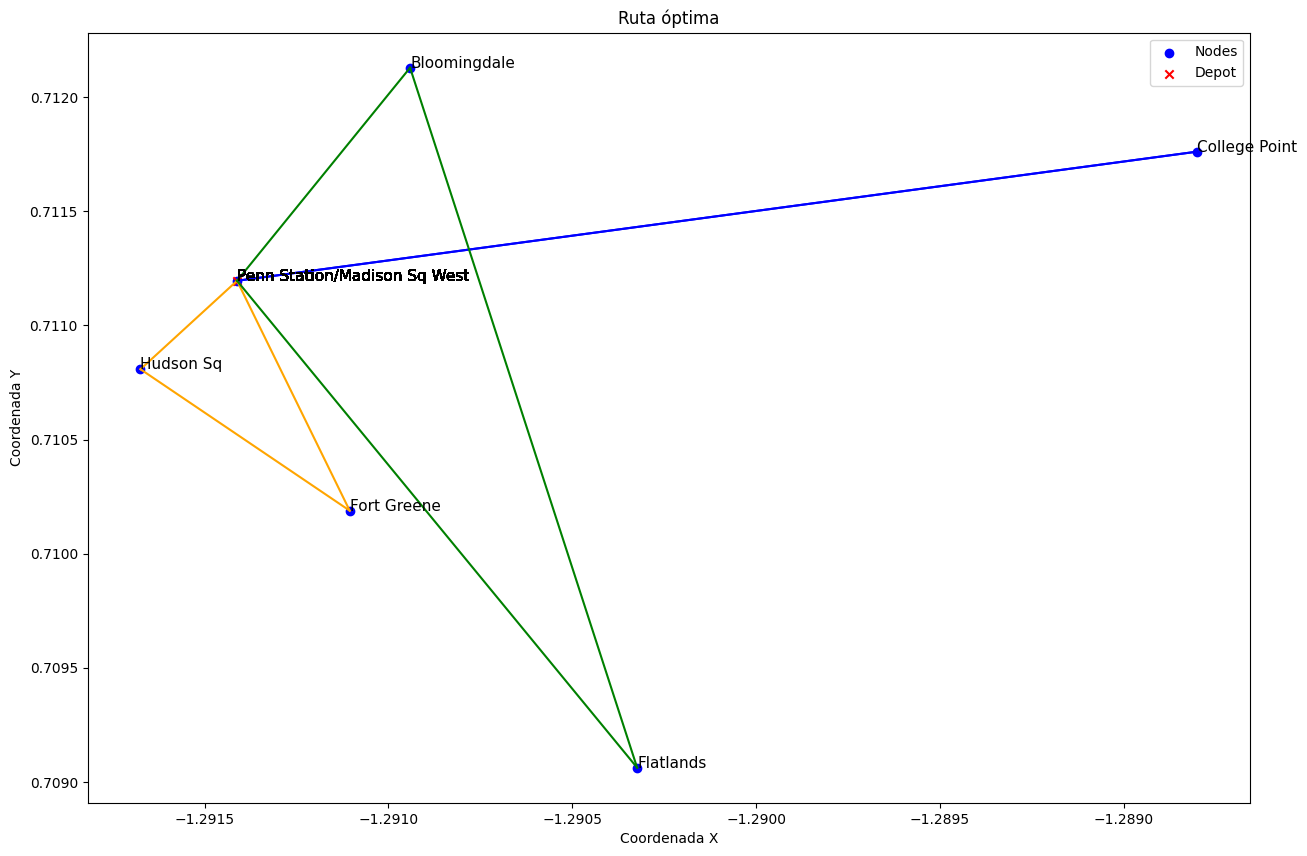

Route for vehicle 0:
 Penn Station/Madison Sq West -> College Point -> Penn Station/Madison Sq West

Route for vehicle 1:
 Penn Station/Madison Sq West -> Hudson Sq -> Fort Greene -> Penn Station/Madison Sq West

Route for vehicle 2:
 Penn Station/Madison Sq West -> Flatlands -> Bloomingdale -> Penn Station/Madison Sq West

Total cost (distance): 37.00 miles


In [71]:
# Define the zones to use and their demands
zones = ['Penn Station/Madison Sq West', 'Bloomingdale', 'College Point', 'Hudson Sq','Flatlands', 'Fort Greene']
demands = {'Penn Station/Madison Sq West': 0, 'Bloomingdale': 2, 'College Point': 3, 'Hudson Sq':1, 'Flatlands':1, 'Fort Greene':2}

# Assign demands to the data
merged_data['demand'] = merged_data['zone'].map(demands).fillna(0)

# Define vehicle capacities
vehicle_capacities = [4, 3,3] 

# Apply the genetic algorithm
route_labels, total_cost = genetic_algorithm_vrp(merged_data, zones, vehicle_capacities, popsize=250,iterations=50, threshold_distance=50)


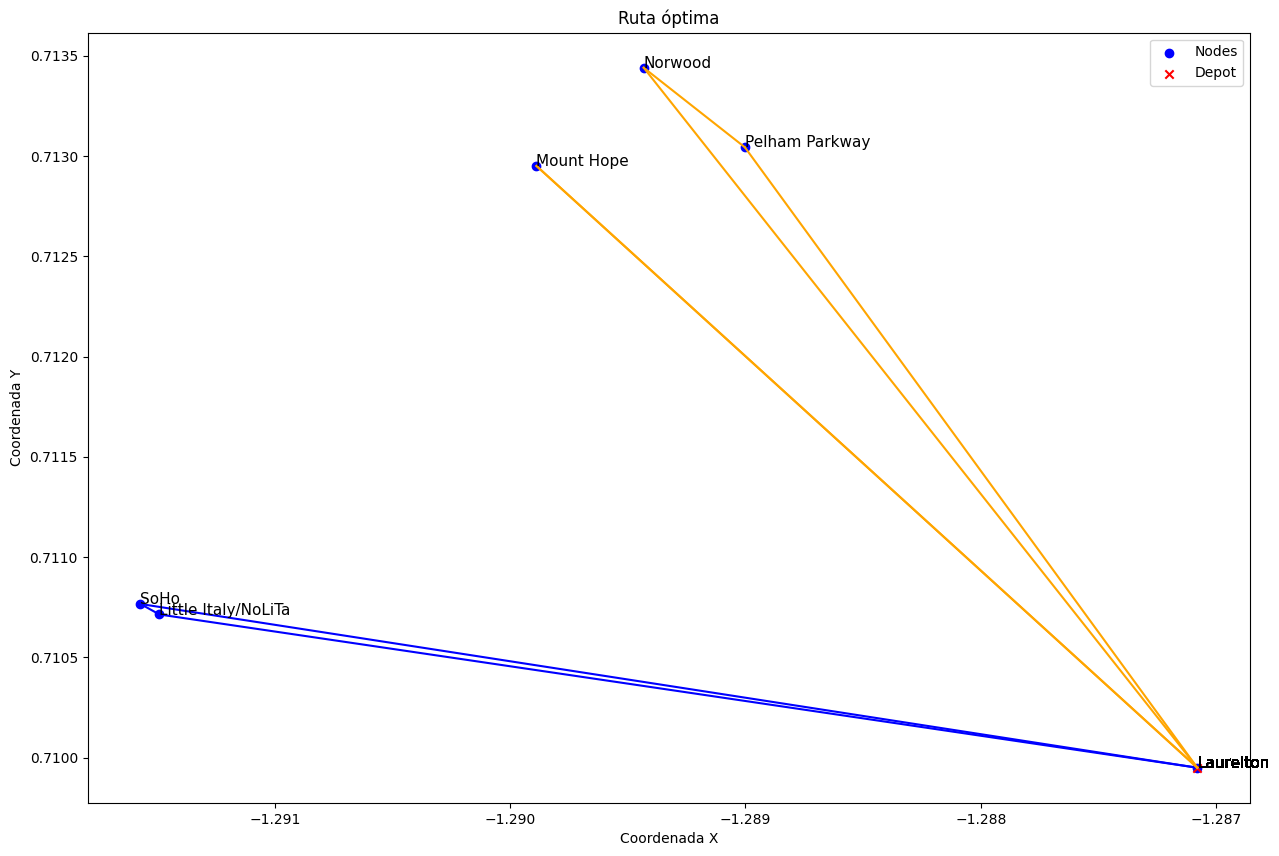

Route for vehicle 0:
 Laurelton -> SoHo -> Little Italy/NoLiTa -> Laurelton

Route for vehicle 1:
 Laurelton -> Norwood -> Pelham Parkway -> Mount Hope -> Laurelton

Route for vehicle 2:
 Laurelton -> Laurelton

Total cost (distance): 78.98 miles
Optimal route:
Laurelton -> SoHo -> Little Italy/NoLiTa -> Laurelton
Laurelton -> Norwood -> Pelham Parkway -> Mount Hope -> Laurelton
Laurelton -> Laurelton
Total cost: 78.98


In [91]:
# Define the zones to use and their demands
zones = ['Laurelton', 'Little Italy/NoLiTa', 'Mount Hope', 'Norwood','Pelham Parkway', 'SoHo']
demands = {'Laurelton': 0, 'Little Italy/NoLiTa': 1,'Mount Hope': 2, 'Norwood': 3, 'Pelham Parkway':1, 'SoHo':2}

# Assign demands to the data
merged_data['demand'] = merged_data['zone'].map(demands).fillna(0)

# Define vehicle capacities
vehicle_capacities = [4, 4,3] 

# Apply the genetic algorithm
route_labels, total_cost = genetic_algorithm_vrp(merged_data, zones, vehicle_capacities, popsize=250,iterations=50, threshold_distance=50)

# Print the solution
print('Optimal route:')
for vehicle_route in route_labels:
    print(' -> '.join(vehicle_route))
print(f'Total cost: {total_cost:.2f}')